In [1]:
parent = dict()
rank = dict()

#vertice 초기화 - 본인 스스로 집합 생성
def make_set(vertice):
    parent[vertice] = vertice
    rank[vertice] = 0

#해당 vertice의 최상위 정점을 찾는다 - naive 한 접근 방식
def find(vertice):
    if parent[vertice] != vertice:
        parent[vertice] = find(parent[vertice])
    return parent[vertice]

#두 정점을 연결한다
def union(vertice1, vertice2):
    root1 = find(vertice1)
    root2 = find(vertice2)
    if root1 != root2:
        if rank[root1] > rank[root2]:
            parent[root2] = root1
        else:
            parent[root1] = root2
            if rank[root1] == rank[root2]: 
                rank[root2] += 1

def kruskal(graph):
    minimum_spanning_tree = []

    #초기화
    for vertice in graph['vertices']:
        make_set(vertice)
        
    #간선 weight 기반 sorting - weight 적은 것 앞으로
    edges = graph['edges']
    edges.sort(reverse=True)
    
    #간선 연결 (사이클 없게)
    for edge in edges:
        weight, vertice1, vertice2 = edge
        if find(vertice1) != find(vertice2): # 같은 집합이 아닐 경우 합침
            union(vertice1, vertice2)
            minimum_spanning_tree.append(edge)
	    
    return minimum_spanning_tree

# graph = {
#     'vertices': ['A', 'B', 'C', 'D', 'E', 'F', 'G'],
#     'edges': [
#         (7, 'A', 'B'),
#         (5, 'A', 'D'),
#         # (7, 'B', 'A'),
#         (8, 'B', 'C'),
#         (9, 'B', 'D'),
#         (7, 'B', 'E'),
#         # (8, 'C', 'B'),
#         (5, 'C', 'E'),
#         # (5, 'D', 'A'),
#         # (9, 'D', 'B'),
#         (7, 'D', 'E'),
#         (6, 'D', 'F'),
#         # (7, 'E', 'B'),
#         # (5, 'E', 'C'),
#         # (7, 'E', 'D'),
#         (8, 'E', 'F'),
#         (9, 'E', 'G'),
#         # (6, 'F', 'D'),
#         # (8, 'F', 'E'),
#         (11, 'F', 'G'),
#         # (9, 'G', 'E'),
#         # (11, 'G', 'F')
#     ]
# }

# 만들어진 graph load
# import json
# with open('data.json', 'r') as file:
#     graph = json.load(file)

In [2]:
# edge 들의 위, 경도 가져오기
import pandas as pd

df = pd.read_csv('강서구_공원데이터_0420.csv')
df.head()

,Unnamed: 0,이름,구분,소재지지번주소,위도,경도,면적,유치거리,행정동명,id,보유시설수,지하철접근도,버스접근도,거주인구,유동인구수,주위공원면적,value
0,0,우장,근린공원,서울특별시 강서구 화곡동 산60-1,37.550402,126.843560,359435.2,1299.764574,우장산동,37.5504021_126.8435599,8,113.283549,4014.275526,150536.0,222947.323201,578586.830799,255280.124354
1,1,화곡2주구1,어린이공원,서울특별시 강서구 화곡동1159-2,37.550247,126.838677,2438.3,274.689573,우장산동,37.5502465_126.8386773,2,90.058362,495.819960,10863.0,1512.407405,38417.459241,14738.797814
2,2,화곡2주구2,어린이공원,서울특별시 강서구 화곡동1159-3,37.548740,126.838710,2438.2,274.689066,우장산동,37.5487397_126.8387097,3,113.225320,792.325737,12119.0,1512.345378,18541.297678,14766.813392
3,3,범바위,어린이공원,서울특별시 강서구 화곡동1061-36,37.543123,126.841565,973.6,265.601282,우장산동,37.5431228_126.8415652,1,228.612345,3202.411077,5488.0,603.896096,4751.017563,12780.403451
4,4,개나리,어린이공원,서울특별시 강서구 화곡동75-3,37.548391,126.844113,285.0,258.440972,우장산동,37.5483914_126.8441132,1,0.000000,240.862578,5809.0,176.777308,82844.055853,6368.060454


In [3]:
"""
1. 공원 csv 읽어오기
2. 이중 for loop으로 하나의 공원에서 모든 공원사이의 거리 구해서 top N개의 공원만 간선으로 연결하기 위한 후보로 추출
3. 간선의 weight 구하기
4. 최종 return : 모든 공원에 대해 top N 개의 간선으로 연결된 graph return
"""

import pandas as pd
from tqdm import tqdm
from geopy.distance import geodesic
import random
import json

def read_file(filename):
    df = pd.read_csv(filename)
    # id가 없을 경우 id 값 부여
    if 'id' not in list(df.columns):
        df["id"] = [i for i in df.index]
        df.to_csv('data.csv')
    return df

def get_node(df, N):
    result = {}

    for i in tqdm(range(len(df.index))):
        temp = []
        park1_id = df['id'][i]
        for j in range(len(df.index)):
            if i != j:
                park1 = (df['위도'][i], df['경도'][i])
                park2 = (df['위도'][j], df['경도'][j])
                distance = geodesic(park1, park2)
                park2_id = df['id'][j]

                temp.append((distance, park2_id))
        temp.sort(reverse=False)
        
        # 가장 가까운 N번째 노드 결과에 할당
        result[park1_id] = temp[:N]
    
    # return 형식 : {id : [(distanace, id),(distanace, id),(distanace, id),(distanace, id)], ... }
    return result

def get_vertex_weight(df, nodes):
    edges = []
    
    for node, values in nodes.items():
        for val in values:
            dest = val[1]
            weight = float(df[df['id']==node]['value']) + float(df[df['id']==dest]['value'])
            edges.append((float(weight), node, dest))

    # return 형식 : [(weight, node1, node2), (weight, node1, node2), ...]
    return edges

def make_graph(vertices, edges):
    graph = {}
    graph['vertices'] = vertices
    graph['edges'] = edges

    return graph

def get_graph(filename, N):
    # 1. 공원 csv 읽어오기 - 필요한 것은 각 공원의 id, 위도, 경도
    df = read_file(filename)
    
    # 2. 이중 for loop으로 하나의 공원에서 모든 공원사이의 거리 구해서 top N개의 공원만 간선으로 연결하기 위한 후보로 추출
    nodes = get_node(df, N)
    
    # 3. 간선의 weight 구하기
    edges = get_vertex_weight(df, nodes)

    # 4. graph 자료구조 init
    graph = make_graph(list(df['id']), edges)

    # 5. output txt 로 저장
    print(graph)
    with open('data.json', 'w') as fp:
        json.dump(graph, fp)

    return graph

In [4]:
# 그래프 자료구조 만들기
graph = get_graph('강서구_공원데이터_0420.csv', 3)

100%|████████████████████████████████████████████████████████████████████████████████| 151/151 [00:05<00:00, 26.73it/s]


{'vertices': ['37.5504021_126.8435599', '37.5502465_126.8386773', '37.5487397_126.8387097', '37.5431228_126.8415652', '37.5483914_126.8441132', '37.5461912_126.8369568', '37.545179_126.8405028', '37.5572794_126.842133', '37.5559649_126.8377431', '37.5561559_126.8400134', '37.5741566_126.8407987', '37.5699353_126.8503191', '37.5698035_126.8318322', '37.5718447_126.8442622', '37.5686973_126.848707', '37.5702207_126.8470783', '37.5698213_126.8448049', '37.5702049_126.825621', '37.5736917_126.836338', '37.5662369_126.8463113', '37.5619946_126.8363522', '37.5706894_126.8278971', '37.5674236_126.8381378', '37.56096_126.8305285', '37.5591297_126.8372148', '37.5579009_126.8688619', '37.5482766_126.8743826', '37.551178_126.8694814', '37.5516964_126.8752946', '37.5498073_126.8706339', '37.5517325_126.8738658', '37.5781568_126.816935', '37.580923_126.8144765', '37.5739069_126.8210288', '37.5829115_126.7988702', '37.577978_126.810609', '37.5786405_126.8143992', '37.5793939_126.8103107', '37.576086

# 알고리즘 적용 전 Graph 지도에 매핑

In [5]:
def conv_edges(input_list):
    res = []
    for t in input_list:
        _, s, d = t
        node1 = list(map(float, s.split('_')))
        node2 = list(map(float, d.split('_')))
        res.append((node1, node2))
    return res

def kruskal_edges(input_list):
    res = []
    for e in input_list:
        _, s, d = e
        node1 = list(map(float, s.split('_')))
        node2 = list(map(float, s.split('_')))
        res.append((node1,node2))
    return res

In [6]:
# 해당 결과 시각화
import folium

# 공원 좌표 정보
locations = [tuple(map(float, (x.split('_')))) for x in graph['vertices']]
# 공원 edge 정보
edges = conv_edges(graph['edges'])

# 지도의 중심 좌표 설정
center = [37.55282,126.843808]

# 지도 (Map) 그리기
m = folium.Map(location=center, zoom_start=13, tiles='cartodbpositron',)

# 점(Circle) 찍기
for i, location in enumerate(locations):
    folium.Circle(
        radius=50,
        location=location,
        # tooltip=train['next_station'].loc[i],
        fill=True
    ).add_to(m)

# 경로(PolyLIne) 추가
for edge in edges:
    folium.PolyLine(locations=edge).add_to(m)

m

# Kruskal 알고리즘 적용

In [7]:
kruskal_graph = kruskal(graph)

In [8]:
# 해당 결과 시각화
import folium

# 공원 edge 정보
kruskal_edges = conv_edges(kruskal_graph)

# 지도의 중심 좌표 설정
center = [37.55282,126.843808]

# 지도 (Map) 그리기
m = folium.Map(location=center, zoom_start=13, tiles='cartodbpositron',)

# 점(Circle) 찍기
for i, location in enumerate(locations):
    folium.Circle(
        radius=50,
        location=location,
        # tooltip=train['next_station'].loc[i],
        fill=True
    ).add_to(m)

# 경로(PolyLIne) 추가
for edge in kruskal_edges:
    folium.PolyLine(locations=edge).add_to(m)

m

# 실증 파트 - 해당 결과에서, 실제로 공원이 이미 존재하는 간선 시각화하기

In [9]:
# 지적편집도 polygon 가져오기
df_green = pd.read_csv('공원_지적편집도.csv')
df_green.head(3)

,pnu,jibun,bchk,sgg_oid,col_adm_se,geometry,lat,lon,polygon
0,1150010600107570002,757-2 공,1,143940,11500,POLYGON ((184318.99000000022 449685.7699999995...,37.549358,126.823570,[[ 37.54925344 126.8233539 ]\n [ 37.54949271 1...
1,1150010600107570004,757-4 공,1,143959,11500,POLYGON ((184253.51999999955 449642.9700000006...,37.548977,126.822976,[[ 37.5488667 126.82261397]\n [ 37.54889121 1...
2,1150010600107570006,757-6 공,1,143963,11500,"POLYGON ((184127.1900000004 449604.9600000009,...",37.548667,126.821848,[[ 37.54852206 126.82118525]\n [ 37.54850712 1...


In [10]:
import ast
import re
from shapely.geometry import Polygon

def create_polygon_list(df):
    polygon_list = []
    for i in range(len(df)):
        p = df['polygon'][i]
        # 문자열에서 숫자 사이에 쉼표 추가
        str_arr = re.sub(r'(?<=[0-9])\s+(?=[0-9])', ', ', p)
        # 숫자 사이에 , 추가
        str_coords = str_arr.replace('[ ', '[').replace('\n [', ',[').replace(' ]', ']').replace(']\n', '],')
        # 문자열을 리스트로 변환
        coords = ast.literal_eval(str_coords)
        # Polygon 객체 생성
        polygon = Polygon(coords)
        # Polygon 객체를 리스트에 추가
        polygon_list.append(polygon)
    return polygon_list

# Polygon 객체들을 담은 리스트 생성
polygon_list = create_polygon_list(df_green)

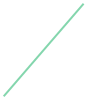

In [11]:
from shapely.geometry import Point, Polygon, LineString
line = kruskal_edges[0]
# print(tuple(line[0]), tuple(line[1]))
edge = LineString([line[0], line[1]])
edge

In [12]:
# 해당 결과 시각화
import folium
from shapely.geometry import Point, Polygon, LineString

# 지도의 중심 좌표 설정
center = [37.55282,126.843808]
# 지도 (Map) 그리기
m = folium.Map(location=center, zoom_start=13, tiles='cartodbpositron',)

# 점(Circle) 찍기
for i, location in enumerate(locations):
    folium.Circle(
        radius=50,
        location=location,
        # tooltip=train['next_station'].loc[i],
        fill=True
    ).add_to(m)

for line in kruskal_edges:
    edge = LineString([line[0],line[1]])
    temp = 0
    # polygon list 순회하면서 통과하는지 확인
    for polygon in polygon_list:
        if edge.intersects(polygon):
            # 교차하는 경우, 교차하는 부분의 길이를 구하고, 해당 길이가 전체 간선 길이의 50% 이상인지 확인
            intersection = edge.intersection(polygon)
            temp += intersection.length

    if temp >= edge.length * 0.5:
        # 조건을 만족하는 경우, 해당 간선을 초록색 표시 - 이미 존재하는 경우
        folium.PolyLine(locations=line, color='green').add_to(m)
    elif temp >= edge.length * 0.1:
        # 겹치긴 하지만, 0.5 이상이 아닌 경우, 가능성이 존재하는 경우.
        folium.PolyLine(locations=line, color='blue').add_to(m)
    else: # 아예 겹치지 않는 경우
        folium.PolyLine(locations=line, color='red').add_to(m)

# Folium 지도 출력
m